In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import base, datasets, dummy, ensemble, linear_model, metrics, model_selection, multiclass, neighbors, preprocessing, svm

In [2]:
%matplotlib inline

# MNIST

In [3]:
mnist = datasets.fetch_openml("mnist_784", version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
# MNIST data has already been split into training and testing data
training_features, testing_features = np.split(mnist["data"], [60000])

In [6]:
training_features.shape

(60000, 784)

In [7]:
testing_features.shape

(10000, 784)

In [8]:
_training_target, _testing_target = np.split(mnist["target"], [60000])
training_target = _training_target.astype(np.uint8)
testing_target = _testing_target.astype(np.uint8)

In [9]:
training_target.shape

(60000,)

In [10]:
testing_target.shape

(10000,)

# Training a Binary Classifier

In [11]:
# classifies whether or not an image is a 5
_prng = np.random.RandomState(42)
is_five = (training_target == 5)
five_classifier = linear_model.SGDClassifier(random_state=_prng)
five_classifier.fit(training_features, is_five)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=RandomState(MT19937) at 0x150C7CB69CA8,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

# Performance Measures

## Measuring accuracy usng cross-validation

In [12]:
# hand-rolled CV to give you intuition as to what is going on (N.B. for loop is trivially parallel!)
_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)

for training_idxs, validation_idxs in stratified_k_fold.split(training_features, is_five):
    _clf = base.clone(five_classifier)
    _clf.fit(training_features[training_idxs], is_five[training_idxs])
    _predictions = _clf.predict(training_features[validation_idxs])
    print(np.mean(_predictions == is_five[validation_idxs]))


0.9612
0.96375
0.96475


In [13]:
# prefer the library implementation where possible
_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
accuracy_scores = model_selection.cross_val_score(five_classifier, training_features, is_five, cv=stratified_k_fold, n_jobs=3, verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s finished


In [14]:
accuracy_scores

array([0.9612 , 0.96375, 0.96475])

In [15]:
# dummy classifier that never classifies anything as a five will be right 90% of the time
never_five_classifier = dummy.DummyClassifier(strategy="constant", constant=0)

_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
accuracy_scores = model_selection.cross_val_score(never_five_classifier, training_features, is_five, cv=stratified_k_fold, n_jobs=3, verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.9s finished


In [16]:
accuracy_scores

array([0.90965, 0.90965, 0.90965])

## Confusion Matrix

In [17]:
_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
predicted_fives = model_selection.cross_val_predict(five_classifier, training_features, is_five, cv=stratified_k_fold, n_jobs=3, verbose=10)

# rows are the actual classes; columns are the predicted classes
confusion_matrix = metrics.confusion_matrix(is_five, predicted_fives)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.4s finished


In [18]:
# calculating precision by hand...
true_positives = confusion_matrix[1,1]
false_positives = confusion_matrix[0, 1]
true_positives / (true_positives + false_positives)

0.8774360178445645

In [19]:
# ...and with library code
precision_score = metrics.precision_score(is_five, predicted_fives)
precision_score

0.8774360178445645

In [20]:
# calculating recall by hand...
false_negatives = confusion_matrix[1, 0]
true_positives / (true_positives + false_negatives)

0.6893562073418189

In [21]:
# ...and with library code
recall_score = metrics.recall_score(is_five, predicted_fives)
recall_score

0.6893562073418189

In [22]:
# f1 score is the harmonic mean of precision and recall
2 / ((1 / precision_score) + (1 / recall_score))

0.772107438016529

In [23]:
f1_score = metrics.f1_score(is_five, predicted_fives)
f1_score

0.7721074380165291

## Precision/Recall Tradeoff

In [24]:
# use cross validation to compute the decision scores
_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
decision_scores = model_selection.cross_val_predict(five_classifier, training_features, is_five, method="decision_function", cv=stratified_k_fold, n_jobs=3, verbose=10)

# compute the precision-recall curve
precision_scores, recall_scores, decision_thresholds = metrics.precision_recall_curve(is_five, decision_scores)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.8s finished


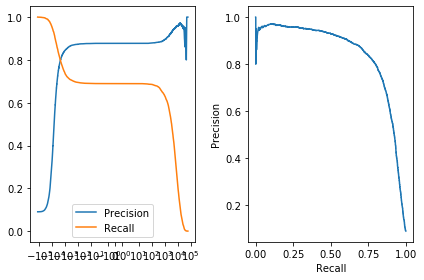

In [25]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(decision_thresholds, precision_scores[:-1], label="Precision")
axes[0].plot(decision_thresholds, recall_scores[:-1], label="Recall")
axes[0].set_xscale("symlog")
axes[0].legend()

axes[1].plot(recall_scores, precision_scores)
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
fig.tight_layout()

plt.show()

## Receiver Operating Characteristic (ROC) Curve

In [26]:
false_positive_rate, true_positive_rate, decision_thresholds = metrics.roc_curve(is_five, decision_scores)

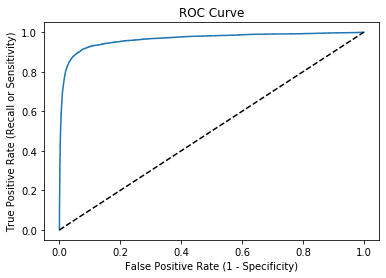

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(false_positive_rate, true_positive_rate)
ax.plot(true_positive_rate, true_positive_rate, "k--")
ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Recall or Sensitivity)")
ax.set_title("ROC Curve")
plt.show()

In [28]:
metrics.roc_auc_score(is_five, decision_scores)

0.964821698911457

As a rule of thumb, you should prefer the Precision-Recall (PR) curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the Receiver Operating Characteristic (ROC) curve. 

In [29]:
_prng = np.random.RandomState(42)
random_forest_classifier = ensemble.RandomForestClassifier(n_estimators=100, random_state=_prng, n_jobs=16)

stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
predicted_fives = model_selection.cross_val_predict(random_forest_classifier, training_features, is_five, cv=stratified_k_fold, n_jobs=3, verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.4s finished


In [30]:
precision_score = metrics.precision_score(is_five, predicted_fives)
recall_score = metrics.recall_score(is_five, predicted_fives)
f1_score = metrics.f1_score(is_five, predicted_fives)
print(f"Precision: {precision_score}, Recall: {recall_score}, F1: {f1_score}")

Precision: 0.9905083315756169, Recall: 0.8662608374838591, F1: 0.9242275142688446


# Multiclass Classification

In [31]:
# multi-class classification using SVM and a One-versus-one (OvO) strategy
_prng = np.random.RandomState(42)
svc = svm.SVC(gamma="scale", decision_function_shape="ovo", random_state=_prng)
svc.fit(training_features, training_target)
ovo_predictions = svc.predict(training_features)

In [32]:
ovo_predictions

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [33]:
ovo_decision_scores = svc.decision_function(training_features)

In [34]:
ovo_decision_scores.shape

(60000, 45)

In [36]:
ovo_decision_scores.argmax(axis=1)

array([35,  5, 34, ..., 35, 21, 35])

In [37]:
# convert binary classifier into multiclass classifier
_prng = np.random.RandomState(42)
svc = svm.SVC(gamma="scale", decision_function_shape="ovo", random_state=_prng)
one_versus_rest_classifier = multiclass.OneVsRestClassifier(svc)
one_versus_rest_classifier.fit(training_features, training_target)
ovr_predictions = one_versus_rest_classifier.predict(training_features)

In [38]:
ovr_decision_scores = one_versus_rest_classifier.decision_function(training_features)

In [39]:
ovr_decision_scores.shape

(60000, 10)

In [40]:
ovr_decision_scores.argmax(axis=1)

array([5, 0, 4, ..., 5, 6, 8])

In [41]:
# training stochastic gradient descent classifier
_prng = np.random.RandomState(42)
sgd_classifier = linear_model.SGDClassifier(n_jobs=10, random_state=_prng)
sgd_classifier.fit(training_features, training_target)
sgd_predictions = sgd_classifier.predict(training_features)

In [42]:
# use cross validation to compute the decision scores
_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
sgd_accuracy_scores = model_selection.cross_val_score(sgd_classifier, training_features, training_target, scoring="accuracy", cv=stratified_k_fold, n_jobs=3, verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   33.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   33.6s finished


In [43]:
sgd_accuracy_scores

array([0.87027594, 0.87759388, 0.8773316 ])

In [44]:
# preprocessing improves accuracy
min_max_scaler = preprocessing.MinMaxScaler()
Z = min_max_scaler.fit_transform(training_features)

_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
sgd_accuracy_scores = model_selection.cross_val_score(sgd_classifier, Z, training_target, scoring="accuracy", cv=stratified_k_fold, n_jobs=3, verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


In [45]:
sgd_accuracy_scores

array([0.90806839, 0.9059453 , 0.91143672])

In [46]:
_prng = np.random.RandomState(42)
random_forest_classifier = ensemble.RandomForestClassifier(n_estimators=100, random_state=_prng, n_jobs=16)

stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
random_forest_predictions = model_selection.cross_val_predict(random_forest_classifier,
                                                              Z,
                                                              training_target,
                                                              cv=stratified_k_fold,
                                                              n_jobs=3,
                                                              verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


In [47]:
_prng = np.random.RandomState(42)
stratified_k_fold = model_selection.StratifiedKFold(n_splits=3, random_state=_prng)
random_forest_accuracy_scores = model_selection.cross_val_score(random_forest_classifier, Z, training_target, scoring="accuracy", cv=stratified_k_fold, n_jobs=3, verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.7s finished


In [48]:
random_forest_accuracy_scores

array([0.96625675, 0.96344817, 0.96714507])

# Error Analysis

In [50]:
metrics.confusion_matrix(training_target, random_forest_predictions)

array([[5845,    1,    9,    0,    4,    7,   18,    1,   35,    3],
       [   1, 6641,   32,   12,   14,    6,    7,   11,   12,    6],
       [  32,   11, 5749,   25,   32,    3,   17,   43,   35,   11],
       [  11,    7,   94, 5805,    2,   63,    7,   48,   62,   32],
       [  11,   10,    9,    0, 5657,    0,   32,   11,   17,   95],
       [  24,    8,   12,   79,   12, 5189,   43,    3,   29,   22],
       [  29,   10,    4,    0,    5,   41, 5814,    0,   15,    0],
       [   7,   19,   62,    7,   42,    0,    0, 6046,    7,   75],
       [  13,   34,   31,   65,   26,   40,   24,    6, 5548,   64],
       [  21,   13,   14,   75,   70,   21,    3,   51,   38, 5643]])

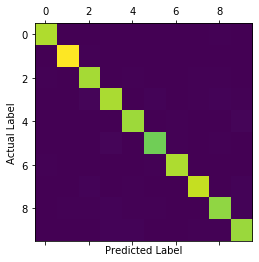

In [59]:
fig, ax = plt.subplots(1, 1)
_confusion_matrix = metrics.confusion_matrix(training_target, random_forest_predictions)
_ = ax.matshow(_confusion_matrix)
_ = ax.set_xlabel("Predicted Label")
_ = ax.set_ylabel("Actual Label")

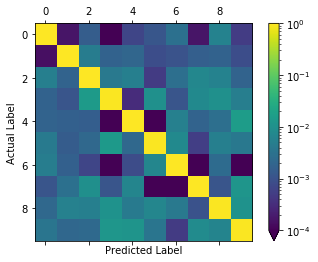

In [89]:
from matplotlib import colors

fig, ax = plt.subplots(1, 1)
_confusion_matrix = metrics.confusion_matrix(training_target, random_forest_predictions)
_normed_confusion_matrix = _confusion_matrix / _confusion_matrix.sum(axis=1, keepdims=True)

_A = np.where(_normed_confusion_matrix < 1e-4, 1e-4, _normed_confusion_matrix)
_image = ax.matshow(_A, norm=colors.LogNorm(1e-4, 1))
_ = ax.set_xlabel("Predicted Label")
_ = ax.set_ylabel("Actual Label")

_ = fig.colorbar(_image, ax=ax, extend='min')

# Multilabel Classification

In [95]:
# can use a one-hot encoding to create multilabel targets
multilabel_training_target = np.c_[training_target >= 7, training_target % 2 == 1]

In [100]:
knn_classifier = neighbors.KNeighborsClassifier()

_prng = np.random.RandomState(42)
k_fold = model_selection.KFold(n_splits=3, random_state=_prng)
knn_accuracy_scores = model_selection.cross_val_score(knn_classifier, Z, multilabel_training_target, scoring="accuracy", cv=k_fold, n_jobs=3, verbose=10)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 17.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 17.9min finished


In [101]:
knn_accuracy_scores

array([0.97475, 0.976  , 0.97315])

# Multioutput Classification

# Exercises

In [110]:
_transformed_training_features = min_max_scaler.fit_transform(training_features)
estimator = neighbors.KNeighborsClassifier()
estimator.fit(_transformed_training_features, training_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [123]:
_param_grid = {
    "n_neighbors": [1, 5, 10, 15],
    "weights": ["uniform", "distance"],
    "leaf_size": [15, 30, 60]
}

_prng = np.random.RandomState(42)
_cv = model_selection.KFold(n_splits=3, random_state=_prng)
grid_search_cv = model_selection.GridSearchCV(estimator, _param_grid, n_jobs=72, cv=_cv, verbose=10)

In [124]:
grid_search_cv.fit(_transformed_training_features, training_target)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   9 out of  72 | elapsed: 54.6min remaining: 382.2min
[Parallel(n_jobs=72)]: Done  17 out of  72 | elapsed: 55.1min remaining: 178.4min
[Parallel(n_jobs=72)]: Done  25 out of  72 | elapsed: 56.6min remaining: 106.5min
[Parallel(n_jobs=72)]: Done  33 out of  72 | elapsed: 57.5min remaining: 67.9min
[Parallel(n_jobs=72)]: Done  41 out of  72 | elapsed: 57.7min remaining: 43.6min
[Parallel(n_jobs=72)]: Done  49 out of  72 | elapsed: 60.9min remaining: 28.6min
[Parallel(n_jobs=72)]: Done  57 out of  72 | elapsed: 61.3min remaining: 16.1min
[Parallel(n_jobs=72)]: Done  65 out of  72 | elapsed: 61.6min remaining:  6.6min
[Parallel(n_jobs=72)]: Done  72 out of  72 | elapsed: 61.8min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=RandomState(MT19937) at 0x150C30017888,
   shuffle=False),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=72,
             param_grid={'leaf_size': [15, 30, 60],
                         'n_neighbors': [1, 5, 10, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch=72, refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [127]:
grid_search_cv.best_params_

{'leaf_size': 15, 'n_neighbors': 5, 'weights': 'distance'}

In [125]:
_transformed_testing_features = min_max_scaler.transform(testing_features)
testing_predictions = grid_search_cv.predict(_transformed_testing_features)

In [126]:
metrics.accuracy_score(testing_target, testing_predictions)

0.9691